In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# import imblearn
import sys, os
import time

import sklearn
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from ann_visualizer.visualize import ann_viz

# Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output classification (Normal/Attack)

In [3]:
train_master = pd.read_csv('nsl_dl/KDDTrain+.csv')
test_master = pd.read_csv('nsl_dl/KDDTest+.csv')

## 1.1 - Import the dataset

In [4]:
train_master

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_lvl
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,150,25,0.17000,0.03000,0.17000,0.00000,0.00000,0.00000,0.05000,0.00000,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00000,0.00000,0.00000,0.00000,0.08000,0.15000,0.00000,255,1,0.00000,0.60000,0.88000,0.00000,0.00000,0.00000,0.00000,0.00000,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00000,1.00000,0.00000,0.00000,0.05000,0.07000,0.00000,255,26,0.10000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20000,0.20000,0.00000,0.00000,1.00000,0.00000,0.00000,30,255,1.00000,0.00000,0.03000,0.04000,0.03000,0.01000,0.00000,0.01000,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.09000,255,255,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.00000,1.00000,0.00000,0.00000,0.14000,0.06000,0.00000,255,25,0.10000,0.06000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,244,0.96000,0.01000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,30,0.12000,0.06000,0.00000,0.00000,0.72000,0.00000,0.01000,0.00000,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.00000,1.00000,0.00000,0.00000,0.06000,0.05000,0.00000,255,8,0.03000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,neptune,20


## 1.2 - Create the dataframes that will be worked on

In [5]:
train = train_master.drop(['difficulty_lvl'], axis = 1)
test = test_master.drop(['difficulty_lvl'], axis = 1)

In [6]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,150,25,0.17000,0.03000,0.17000,0.00000,0.00000,0.00000,0.05000,0.00000,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00000,0.00000,0.00000,0.00000,0.08000,0.15000,0.00000,255,1,0.00000,0.60000,0.88000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00000,1.00000,0.00000,0.00000,0.05000,0.07000,0.00000,255,26,0.10000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20000,0.20000,0.00000,0.00000,1.00000,0.00000,0.00000,30,255,1.00000,0.00000,0.03000,0.04000,0.03000,0.01000,0.00000,0.01000,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.09000,255,255,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.00000,1.00000,0.00000,0.00000,0.14000,0.06000,0.00000,255,25,0.10000,0.06000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,244,0.96000,0.01000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,30,0.12000,0.06000,0.00000,0.00000,0.72000,0.00000,0.01000,0.00000,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.00000,1.00000,0.00000,0.00000,0.06000,0.05000,0.00000,255,8,0.03000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,neptune


### Removes they types of services in sets to equal them

In [7]:
train = train.query("service != 'aol'")
train = train.query("service != 'harvest'")
train = train.query("service != 'http_2784'")
train = train.query("service != 'http_8001'")
train = train.query("service != 'red_i'")
train = train.query("service != 'urh_i'")
train = train.query("service != 'printer'")
train = train.query("service != 'rje'")

test = test.query("service != 'printer'")
test = test.query("service != 'rje'")

## 1.3 - Change the non normal entries to 'attack'
#### *not needed when training for 23 outputs*

In [8]:
train.loc[train.attack_type != 'normal', 'attack_type'] = 'attack'
test.loc[test.attack_type != 'normal', 'attack_type'] = 'attack'

In [9]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,150,25,0.17000,0.03000,0.17000,0.00000,0.00000,0.00000,0.05000,0.00000,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00000,0.00000,0.00000,0.00000,0.08000,0.15000,0.00000,255,1,0.00000,0.60000,0.88000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00000,1.00000,0.00000,0.00000,0.05000,0.07000,0.00000,255,26,0.10000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20000,0.20000,0.00000,0.00000,1.00000,0.00000,0.00000,30,255,1.00000,0.00000,0.03000,0.04000,0.03000,0.01000,0.00000,0.01000,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.09000,255,255,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.00000,1.00000,0.00000,0.00000,0.14000,0.06000,0.00000,255,25,0.10000,0.06000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,attack
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,244,0.96000,0.01000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,255,30,0.12000,0.06000,0.00000,0.00000,0.72000,0.00000,0.01000,0.00000,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.00000,1.00000,0.00000,0.00000,0.06000,0.05000,0.00000,255,8,0.03000,0.05000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,attack


## 1.4 - Scale and encode
### Encoding the attack_type column to become the output target 

In [10]:
ytrain = pd.get_dummies(train['attack_type'])
ytest = pd.get_dummies(test['attack_type'])

## drop the columns after encoding
train = train.drop(['attack_type'], axis = 1)
test = test.drop(['attack_type'], axis = 1)

In [11]:
ytrain

,attack,normal
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1
...,...,...
125968,1,0
125969,0,1
125970,0,1
125971,1,0


### Encode protocol, service and flag features

In [12]:
proto_ohe_train = pd.get_dummies(train['protocol_type'])
proto_ohe_test = pd.get_dummies(test['protocol_type'])

service_ohe_train = pd.get_dummies(train['service'])
service_ohe_test = pd.get_dummies(test['service'])

flag_ohe_train = pd.get_dummies(train['flag'])
flag_ohe_test = pd.get_dummies(test['flag'])

In [13]:
proto_ohe_train

,icmp,tcp,udp
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
125968,0,1,0
125969,0,0,1
125970,0,1,0
125971,0,1,0


## 1.5 - Replace the original features with the OHE features 

In [14]:
train = train.drop(['protocol_type', 'service', 'flag'], axis = 1)
test = test.drop(['protocol_type', 'service', 'flag'], axis = 1)

xtrain = pd.concat([train, proto_ohe_train, service_ohe_train, flag_ohe_train], axis = 1)
xtest = pd.concat([test, proto_ohe_test, service_ohe_test, flag_ohe_test], axis = 1)

## 1.6 - Scale the features between 0 and 255 to correspond to pixel values

In [14]:
xtrain = (xtrain/255.0).round(0)
xtest = (xtest/255.0).round(0)

## 1.6a - Scale features using MinMax

In [15]:
scaler = MinMaxScaler()

xtrain = scaler.fit_transform(xtrain)
xtest = scaler.fit_transform(xtest)

## 1.7 - Convert df to numpy array and reshape

In [16]:
xtrain = xtrain.to_numpy()
xtest = xtest.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [17]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtrain.shape

(125793, 114, 1)

In [18]:
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))
xtest.shape

(22525, 114, 1)

In [19]:
ytrain.shape, ytest.shape

((125793, 2), (22525, 2))

In [20]:
cnn = Sequential()

## convolution 1
cnn.add(Convolution1D(16, 3, padding="same", activation='relu', input_shape = (xtrain.shape[1], 1)))
cnn.add(MaxPooling1D(pool_size = (2)))
# cnn.add(Dropout(0.5))

## convolution 2
cnn.add(Convolution1D(32, 3, padding="same", activation='relu'))
cnn.add(MaxPooling1D(pool_size = (2)))
# cnn.add(Dropout(0.5))

## convolution 3
cnn.add(Convolution1D(64, 3, padding="same", activation='relu'))
cnn.add(MaxPooling1D(pool_size = (2)))
# cnn.add(Dropout(0.5))

## convolution 4
cnn.add(Convolution1D(128, 3, padding="same", activation='relu'))
cnn.add(MaxPooling1D(pool_size = (2)))
# cnn.add(Dropout(0.5))

## convolution 5
cnn.add(Convolution1D(256, 3, padding="same", activation='relu'))
cnn.add(MaxPooling1D(pool_size = (2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(len(ytrain.columns), activation = 'softmax'))

callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 114, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 57, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 57, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 28, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 64)            6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 128)           2

In [21]:
start = time.time()

model_history = cnn.fit(xtrain, ytrain, batch_size = 200, epochs = 200)

end = time.time() - start

print(f'Training for ANN took {round(end,3)} seconds')

Epoch 1/200
629/629 [==============================] - 11s 17ms/step - loss: 0.0645 - accuracy: 0.9788
Epoch 2/200
629/629 [==============================] - 12s 18ms/step - loss: 0.0283 - accuracy: 0.9901
Epoch 3/200
629/629 [==============================] - 12s 19ms/step - loss: 0.0193 - accuracy: 0.9936
Epoch 4/200
629/629 [==============================] - 12s 19ms/step - loss: 0.0164 - accuracy: 0.9946
Epoch 5/200
629/629 [==============================] - 12s 20ms/step - loss: 0.0147 - accuracy: 0.9952
Epoch 6/200
629/629 [==============================] - 13s 20ms/step - loss: 0.0135 - accuracy: 0.9955
Epoch 7/200
629/629 [==============================] - 13s 20ms/step - loss: 0.0123 - accuracy: 0.9957
Epoch 8/200
629/629 [==============================] - 13s 21ms/step - loss: 0.0118 - accuracy: 0.9957
Epoch 9/200
629/629 [==============================] - 13s 21ms/step - loss: 0.0105 - accuracy: 0.9962
Epoch 10/200
629/629 [==============================] - 13s 21ms/step - l

In [67]:
cnn.save('cnn_out2.h5')

dict_keys(['loss', 'accuracy'])


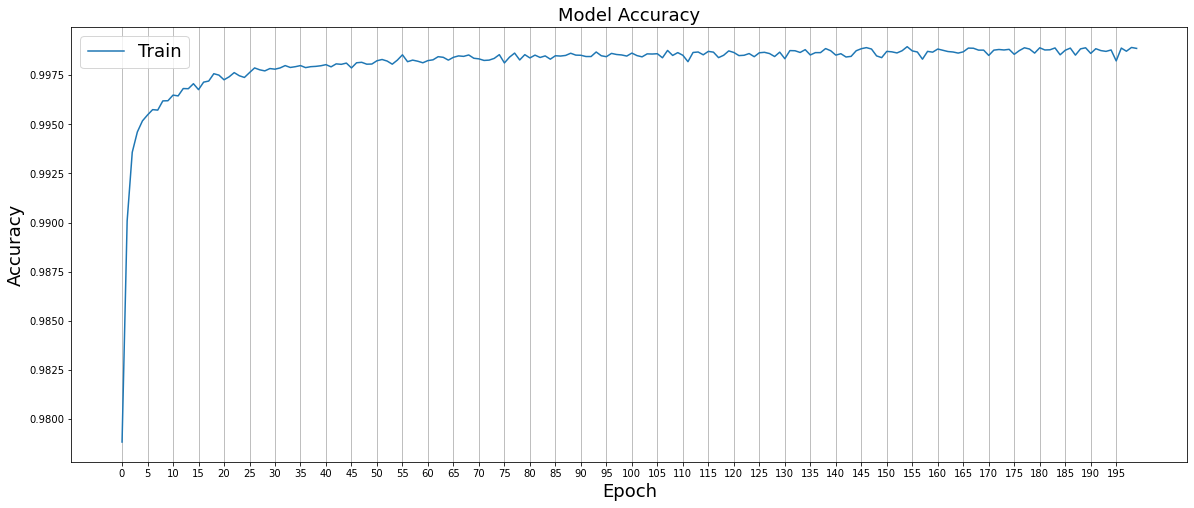

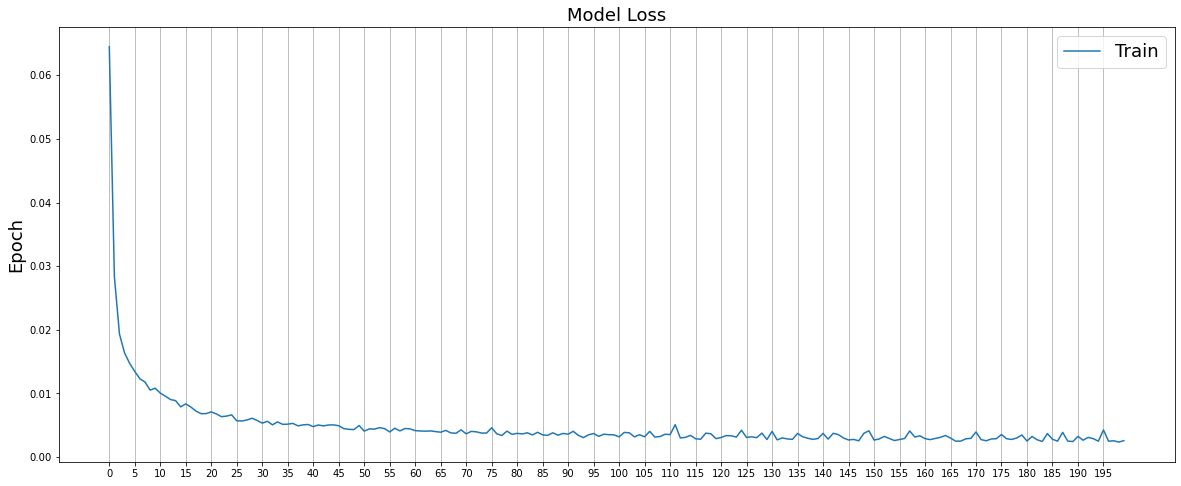

In [22]:
print(model_history.history.keys())

figure(figsize = (20,8))
plt.plot(model_history.history['accuracy'])
# plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 200, step = 5))
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

figure(figsize = (20,8))
plt.plot(model_history.history['loss'], )
# plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 200, step = 5), )
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

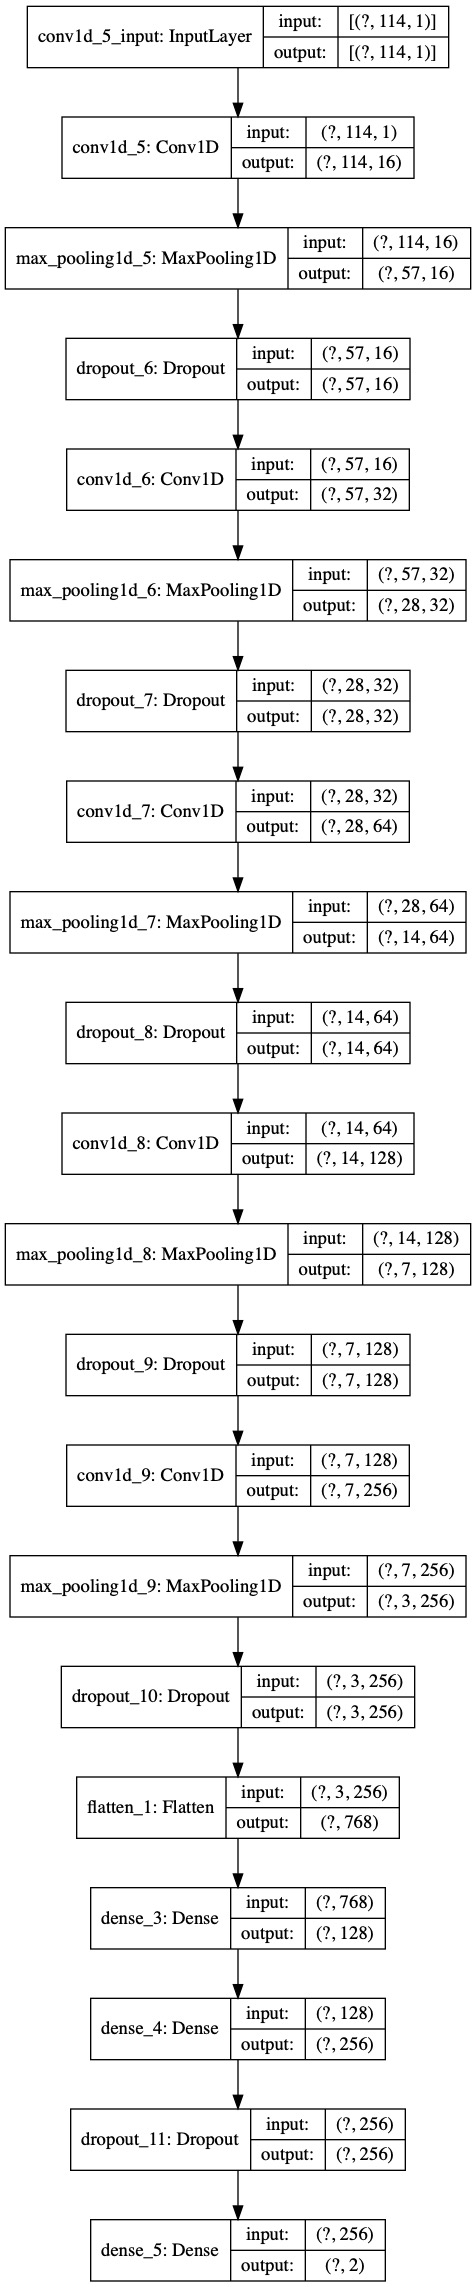

In [70]:
tf.keras.utils.plot_model(cnn, 'cnn_model.jpg', show_shapes = 1)

In [23]:
loss, acc = cnn.evaluate(xtest, ytest, batch_size = 200, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 6.6879	Accuracy = 79.43%


In [24]:
preds = cnn.predict(xtest)
y_preds = np.argmax(preds, axis = 1)

In [ ]:
preds

In [26]:
y_preds

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,

In [27]:
CATEGORIES = ['Attack','Normal']
# ATTACKS = ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']
# ATTACKS = [ytest.columns]

check_element = 5

print(f'First n predictions:\n\n {(preds[:10])}\n\n')
print(f'Index array: {(preds[check_element])}\n')
print(f'Largest probability index: {np.argmax(preds[check_element])}')
print(f'Category classification: {CATEGORIES[np.argmax(preds[check_element])]}')

First n predictions:

 [[1.      0.     ]
 [1.      0.     ]
 [0.      1.     ]
 [1.      0.     ]
 [0.65034 0.34966]
 [0.      1.     ]
 [0.00038 0.99962]
 [0.47932 0.52068]
 [0.      1.     ]
 [0.      1.     ]]


Index array: [0. 1.]

Largest probability index: 1
Category classification: Normal


In [81]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution1D(16, 3, padding="same", activation='relu', input_shape = (xtrain.shape[1], 1)))
    cnn.add(MaxPooling1D(pool_size = (2)))
    cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution1D(32, 3, padding="same", activation='relu'))
    cnn.add(MaxPooling1D(pool_size = (2)))
    cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution1D(64, 3, padding="same", activation='relu'))
    cnn.add(MaxPooling1D(pool_size = (2)))
    cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution1D(128, 3, padding="same", activation='relu'))
    cnn.add(MaxPooling1D(pool_size = (2)))
    cnn.add(Dropout(0.5))

    ## convolution 5
    cnn.add(Convolution1D(256, 3, padding="same", activation='relu'))
    cnn.add(MaxPooling1D(pool_size = (2)))
    cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(len(ytrain.columns), activation = 'softmax'))

    cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 200, epochs = 200)

In [82]:
scores = cross_val_score(estimator = classifier, X = xtest, y = ytest, cv = 10, n_jobs = -1)
# accuracy = metrics.accuracy_score(icassp_ytest, yhat_test)
# confusion_matrix = metrics.confusion_matrix(icassp_ytest, yhat_test)
# classification = metrics.classification_report(ytest, preds, target_names = ytest.columns)

print('\n============================== ANN Model Test Results ==============================\n')
# print(f'CNN evaluation took {round(end, 3)} seconds\n')
print(f'Model Cross Validation: \n{round(scores.mean(), 3)*100}%')
# print('\n')
# print (f"Model Accuracy: \n{round(accuracy, 4)*100}%")
# print('\n')
# print("Confusion matrix:" "\n", confusion_matrix)
# print('\n')
# print("Classification report:" "\n", classification)

KeyboardInterrupt: 

In [83]:
scores = cross_val_score(estimator = classifier, X = xtest, y = ytest, cv = 10, n_jobs = -1)
print(f'Model Cross Validation: \n{round(scores.mean(), 3)*100}%')

Model Cross Validation: 
96.7%


In [ ]:
classification = metrics.classification_report(ytest, preds, target_names = ytest.columns)